In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv("newssumm_sample_100.csv").dropna()

train_df, test_df = train_test_split(df, test_size=0.1, random_state=42)
train_df, val_df  = train_test_split(train_df, test_size=0.1, random_state=42)


In [2]:
from transformers import MBart50TokenizerFast

tokenizer = MBart50TokenizerFast.from_pretrained(
    "facebook/mbart-large-50-many-to-many-mmt"
)

tokenizer.src_lang = "en_XX"
tokenizer.tgt_lang = "hi_IN"


c:\Users\shash\.conda\envs\cls_research\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
'(MaxRetryError('HTTPSConnectionPool(host=\'huggingface.co\', port=443): Max retries exceeded with url: /facebook/mbart-large-50-many-to-many-mmt/resolve/main/tokenizer_config.json (Caused by NameResolutionError("HTTPSConnection(host=\'huggingface.co\', port=443): Failed to resolve \'huggingface.co\' ([Errno 11001] getaddrinfo failed)"))'), '(Request ID: dd39970f-52f4-4aa7-bceb-5143f388b061)')' thrown while requesting HEAD https://huggingface.co/facebook/mbart-large-50-many-to-many-mmt/resolve/main/tokenizer_config.json
Retrying in 1s [Retry 1/5].
'(MaxRetryError('HTTPSConnectionPool(host=\'huggingface.co\', port=443): Max retries exceeded with url: /facebook/mbart-large-50-many-to-many-mmt/resolve/main/tokenizer_config.json (C

In [3]:
from transformers import MBartForConditionalGeneration

def load_model():
    return MBartForConditionalGeneration.from_pretrained(
        "facebook/mbart-large-50-many-to-many-mmt"
    )



In [4]:
MAX_INPUT = 1024
MAX_TARGET = 256

def tokenize(batch):
    inputs = tokenizer(
        batch["article_text"],
        truncation=True,
        padding="max_length",
        max_length=MAX_INPUT
    )

    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            batch["summary_text"],
            truncation=True,
            padding="max_length",
            max_length=MAX_TARGET
        )

    inputs["labels"] = labels["input_ids"]
    return inputs


In [5]:
from datasets import Dataset
train_ds = Dataset.from_pandas(train_df, preserve_index=False)
val_ds   = Dataset.from_pandas(val_df, preserve_index=False)
test_ds  = Dataset.from_pandas(test_df)


In [6]:
train_ds = train_ds.map(
    tokenize,
    batched=True,
    remove_columns=["article_text", "summary_text"]
)

val_ds = val_ds.map(
    tokenize,
    batched=True,
    remove_columns=["article_text", "summary_text"]
)


Map:   0%|          | 0/81 [00:00<?, ? examples/s]c:\Users\shash\.conda\envs\cls_research\lib\site-packages\transformers\tokenization_utils_base.py:4169: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
Map: 100%|██████████| 9/9 [00:00<00:00, 381.25 examples/s]


In [7]:
import torch
from torch.optim import AdamW

model_1 = load_model()
optimizer = AdamW(model_1.parameters(), lr=3e-5)

model_1.train()
for epoch in range(3):
    for batch in train_ds:
        inputs = {k: torch.tensor(v).unsqueeze(0) for k, v in batch.items()}
        outputs = model_1(**inputs)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    print(f"Epoch {epoch} completed")


Epoch 0 completed
Epoch 1 completed
Epoch 2 completed


In [8]:
import spacy, re
nlp = spacy.load("en_core_web_sm")

def extract_entities(text):
    return {e.text.lower() for e in nlp(text).ents}

def extract_numbers(text):
    return set(re.findall(r"\d+[\d,]*", text))


In [9]:
def entity_loss(src_text, gen_text):
    src_entities = extract_entities(src_text)
    gen_entities = extract_entities(gen_text)
    return 1 - (len(src_entities & gen_entities) / max(len(src_entities), 1))

def number_loss(src_text, gen_text):
    src_numbers = extract_numbers(src_text)
    gen_numbers = extract_numbers(gen_text)
    return 1 - (len(src_numbers & gen_numbers) / max(len(src_numbers), 1))



In [10]:
model_2 = load_model()
optimizer = AdamW(model_2.parameters(), lr=3e-5)

λ_entity = 0.7
λ_number = 0.3

model_2.train()
for epoch in range(3):
    for batch, raw in zip(train_ds, train_df.itertuples()):
        inputs = {k: torch.tensor(v).unsqueeze(0) for k, v in batch.items()}
        outputs = model_2(**inputs)
        ce_loss = outputs.loss

        gen_ids = model_2.generate(
            input_ids=inputs["input_ids"],
            attention_mask=inputs["attention_mask"],
            max_length=150
        )
        gen_text = tokenizer.decode(gen_ids[0], skip_special_tokens=True)

        f_loss = (
            λ_entity * entity_loss(raw.article_text, gen_text)
            + λ_number * number_loss(raw.article_text, gen_text)
        )

        total_loss = ce_loss + f_loss
        total_loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    print(f"Epoch {epoch} completed")


Epoch 0 completed
Epoch 1 completed
Epoch 2 completed


In [11]:
from rouge_score import rouge_scorer

scorer = rouge_scorer.RougeScorer(["rouge1","rouge2","rougeL"], use_stemmer=True)


In [12]:
from bert_score import score as bertscore


In [13]:
def entity_recall(src, gen):
    s, g = extract_entities(src), extract_entities(gen)
    return len(s & g) / max(len(s), 1)

def number_preservation(src, gen):
    s, g = extract_numbers(src), extract_numbers(gen)
    return len(s & g) / max(len(s), 1)


In [14]:
def evaluate(model, df):
    model.eval()

    rouge1, rouge2, rougel = [], [], []
    ent, num = [], []
    refs, hyps = [], []

    for row in df.itertuples():
        inputs = tokenizer(row.article_text, return_tensors="pt", truncation=True, max_length=1024)
        gen_ids = model.generate(**inputs, max_length=150)
        gen = tokenizer.decode(gen_ids[0], skip_special_tokens=True)

        r = scorer.score(row.summary_text, gen)
        rouge1.append(r["rouge1"].fmeasure)
        rouge2.append(r["rouge2"].fmeasure)
        rougel.append(r["rougeL"].fmeasure)

        ent.append(entity_recall(row.article_text, gen))
        num.append(number_preservation(row.article_text, gen))

        refs.append(row.summary_text)
        hyps.append(gen)

    P, R, F1 = bertscore(hyps, refs, lang="en")

    return {
        "ROUGE-1": sum(rouge1)/len(rouge1),
        "ROUGE-2": sum(rouge2)/len(rouge2),
        "ROUGE-L": sum(rougel)/len(rougel),
        "BERTScore-F1": F1.mean().item(),
        "Entity Recall": sum(ent)/len(ent),
        "Number Preservation": sum(num)/len(num)
    }


In [ ]:
baseline_results = evaluate(model_1, test_df)
factaware_results = evaluate(model_2, test_df)

print("Direct mBART:", baseline_results)
print("FACT-AWARE mBART:", factaware_results)





c:\Users\shash\.conda\envs\cls_research\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\shash\.cache\huggingface\hub\models--roberta-large. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP downlo

Direct mBART: {'ROUGE-1': 0.5427363755915862, 'ROUGE-2': 0.36155061403648625, 'ROUGE-L': 0.44123577049433516, 'BERTScore-F1': 0.9097474813461304, 'Entity Recall': 0.5338277469029306, 'Number Preservation': 0.2808740601503759}
FACT-AWARE mBART: {'ROUGE-1': 0.5591782310969156, 'ROUGE-2': 0.3892344237230324, 'ROUGE-L': 0.4756542117322867, 'BERTScore-F1': 0.9161325693130493, 'Entity Recall': 0.5416380717454771, 'Number Preservation': 0.24486215538847117}


In [16]:
import pandas as pd


# Convert to DataFrame
df = pd.DataFrame([
    {"model": "Direct mBART", **baseline_results},
    {"model": "FACT-AWARE mBART", **factaware_results}
])

# Save to CSV
df.to_csv("evaluation_results.csv", index=False)

print(df)


              model   ROUGE-1   ROUGE-2   ROUGE-L  BERTScore-F1  \
0      Direct mBART  0.542736  0.361551  0.441236      0.909747   
1  FACT-AWARE mBART  0.559178  0.389234  0.475654      0.916133   

   Entity Recall  Number Preservation  
0       0.533828             0.280874  
1       0.541638             0.244862  


In [20]:
comparsion_model = pd.read_csv('evaluation_results.csv')

comparsion_model

,model,ROUGE-1,ROUGE-2,ROUGE-L,BERTScore-F1,Entity Recall,Number Preservation
0,Direct mBART,0.542736,0.361551,0.441236,0.909747,0.533828,0.280874
1,FACT-AWARE mBART,0.559178,0.389234,0.475654,0.916133,0.541638,0.244862


#Comparsion of Baseline Model as well as Novel Model

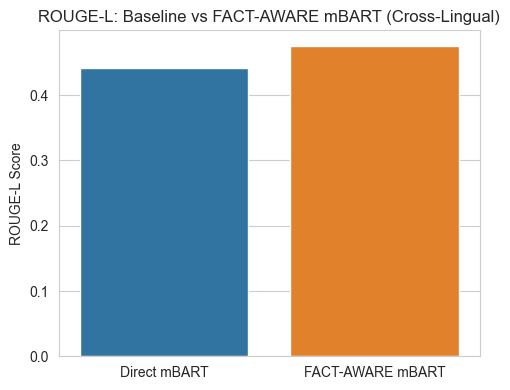

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")

plt.figure(figsize=(5,4))
sns.barplot(
    data=comparsion_model,
    x="model",
    y="ROUGE-L",
    hue="model"
)

plt.title("ROUGE-L: Baseline vs FACT-AWARE mBART (Cross-Lingual)")
plt.ylabel("ROUGE-L Score")
plt.xlabel("")
plt.tight_layout()
plt.show()


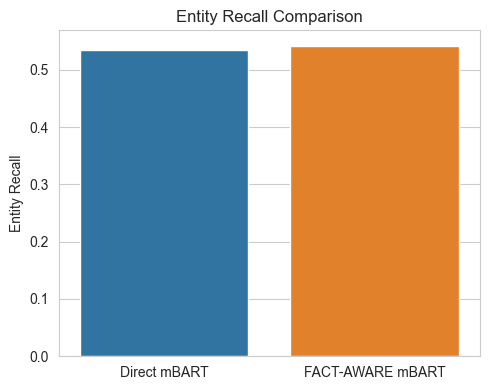

In [42]:
plt.figure(figsize=(5,4))
sns.barplot(
    data=comparsion_model,
    x="model",
    y="Entity Recall",
    hue="model"
)

plt.title("Entity Recall Comparison")
plt.ylabel("Entity Recall")
plt.xlabel("")
plt.tight_layout()
plt.show()


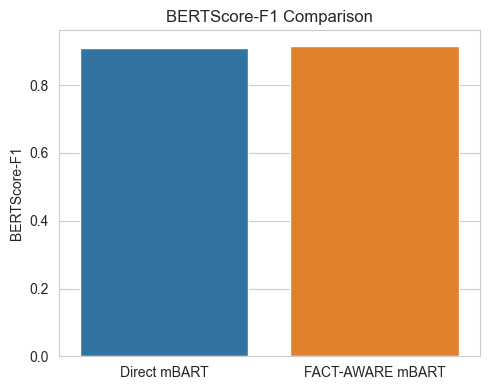

In [48]:
plt.figure(figsize=(5,4))
sns.barplot(
    data=comparsion_model,
    x="model",
    y="BERTScore-F1",
    hue="model"
)

plt.title("BERTScore-F1 Comparison")
plt.ylabel("BERTScore-F1")
plt.xlabel("")
plt.tight_layout()
plt.show()


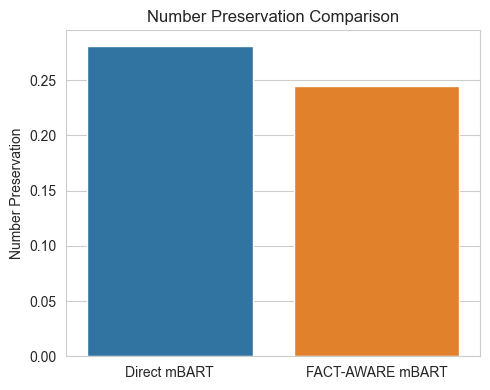

In [49]:
plt.figure(figsize=(5,4))
sns.barplot(
    data=comparsion_model,
    x="model",
    y="Number Preservation",
    hue="model"
)

plt.title("Number Preservation Comparison")
plt.ylabel("Number Preservation")
plt.xlabel("")
plt.tight_layout()
plt.show()


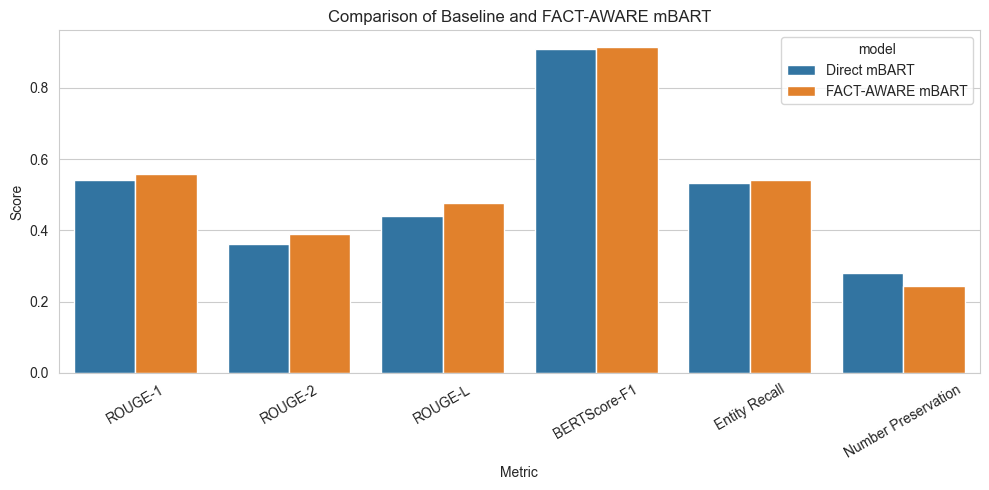

In [27]:
df_melt = df.melt(id_vars="model", var_name="Metric", value_name="Score")

plt.figure(figsize=(10,5))
import seaborn as sns
sns.barplot(data=df_melt, x="Metric", y="Score", hue="model")

plt.xticks(rotation=30)
plt.title("Comparison of Baseline and FACT-AWARE mBART")
plt.tight_layout()
plt.show()


C:\Users\shash\AppData\Local\Temp\ipykernel_16032\2018583048.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\shash\AppData\Local\Temp\ipykernel_16032\2018583048.py:10: UserWarning: 
The palette list has fewer values (2) than needed (3) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(


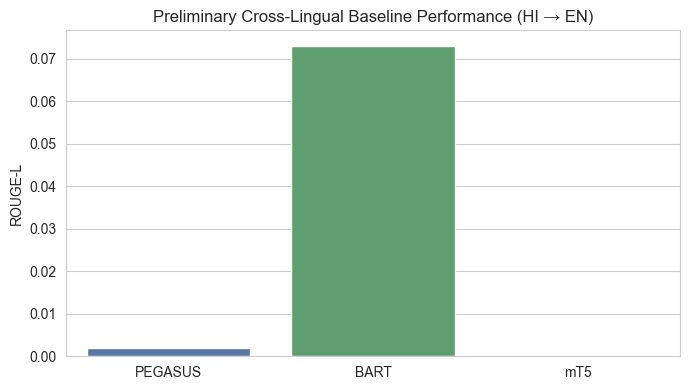

In [37]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("model_comparison_results.csv")

sns.set_style("whitegrid")
plt.figure(figsize=(7,4))

sns.barplot(
    data=df,
    x="Model",
    y="HI→EN_ROUGE-L",
    palette=["#4C72B0", "#55A868"]
)

plt.title("Preliminary Cross-Lingual Baseline Performance (HI → EN)")
plt.ylabel("ROUGE-L")
plt.xlabel("")
plt.tight_layout()
plt.show()


C:\Users\shash\AppData\Local\Temp\ipykernel_16032\1553054839.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\shash\AppData\Local\Temp\ipykernel_16032\1553054839.py:2: UserWarning: 
The palette list has fewer values (2) than needed (3) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(


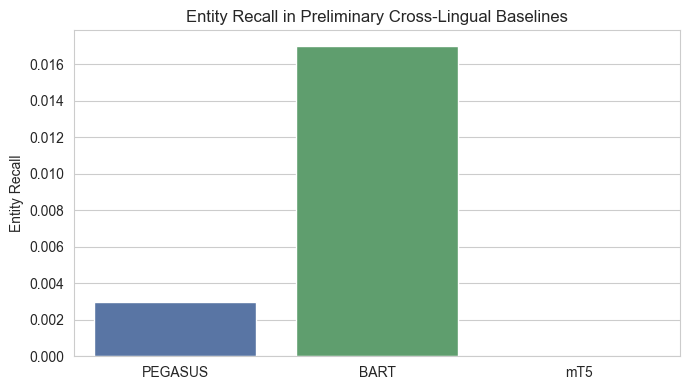

In [38]:
plt.figure(figsize=(7,4))
sns.barplot(
    data=df,
    x="Model",
    y="Entity_Recall",
    palette=["#4C72B0", "#55A868"]
)

plt.title("Entity Recall in Preliminary Cross-Lingual Baselines")
plt.ylabel("Entity Recall")
plt.xlabel("")
plt.tight_layout()
plt.show()


C:\Users\shash\AppData\Local\Temp\ipykernel_16032\3246208124.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(


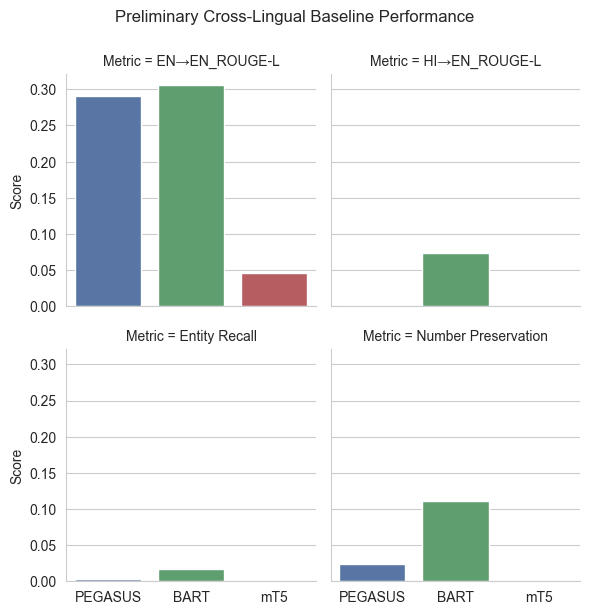

In [39]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame({
    "Model": ["PEGASUS", "BART", "mT5"],
    "EN→EN_ROUGE-L": [0.291, 0.306, 0.046],
    "HI→EN_ROUGE-L": [0.002, 0.073, 0.0],
    "Entity Recall": [0.003, 0.017, 0.0],
    "Number Preservation": [0.024, 0.111, 0.0]
})

df_melt = df.melt(id_vars="Model", var_name="Metric", value_name="Score")

sns.set_style("whitegrid")
g = sns.catplot(
    data=df_melt,
    x="Model",
    y="Score",
    col="Metric",
    kind="bar",
    palette = ["#4C72B0", "#55A868", "#C44E52"],
    col_wrap=2,
    height=3,
    aspect=1
)

g.fig.suptitle("Preliminary Cross-Lingual Baseline Performance", y=1.05)
g.set_axis_labels("", "Score")

plt.show()


In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df1 = pd.DataFrame({
    "Setting": ["Baseline", "Conservative", "Expressive"],
    "HI→EN_ROUGE-L": [0.068, 0.062, 0.060],
    "Entity Recall": [0.016, 0.017, 0.020],
    "Number Preservation": [0.111, 0.079, 0.083]
})

sns.set_style("whitegrid")


C:\Users\shash\AppData\Local\Temp\ipykernel_16032\4078986296.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(


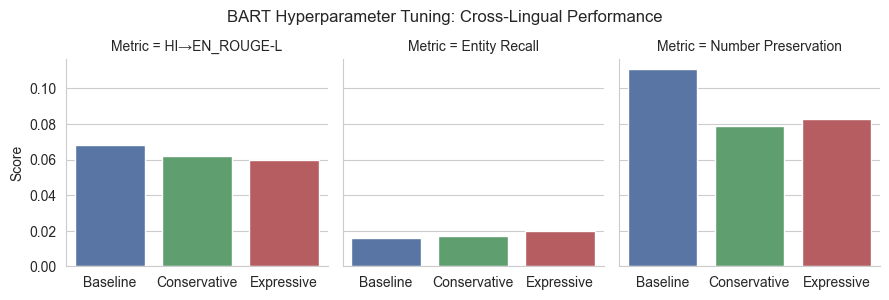

In [35]:
df_melt = df1.melt(id_vars="Setting", var_name="Metric", value_name="Score")

g = sns.catplot(
    data=df_melt,
    x="Setting",
    y="Score",
    col="Metric",
    kind="bar",
    palette= ["#4C72B0", "#55A868", "#C44E52"],
    height=3,
    aspect=1
)

g.fig.suptitle(
    "BART Hyperparameter Tuning: Cross-Lingual Performance",
    y=1.05
)
g.set_axis_labels("", "Score")
plt.show()
